In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

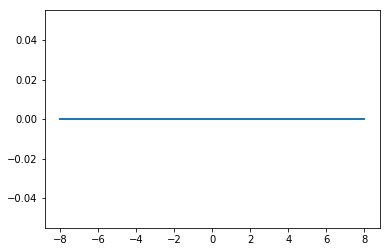

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3
plt.plot(y, [np.around(np.mean(X), decimals=2)]*len(y), lw=2);

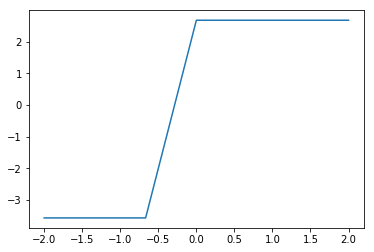

In [3]:
var1, var2 = X[X<0], X[X>=0]
val1 = [np.around(np.mean(y[X<0]), decimals=2)]*len(var1)
val2 = [np.around(np.mean(y[X>=0]), decimals=2)]*len(var2)
plt.plot(np.r_[var1, var2], np.r_[val1, val2]);

In [4]:
def regression_var_criterion(X, y, t):
    len_0 = len(y)
    len_l = len(y[X<t])
    len_r = len(y[X>=t])
    D0 = np.var(y)
    Dl = np.var(y[X<t])
    Dr = np.var(y[X>=t])
    return D0 - len_l / len_0 * Dl - len_r / len_0 * Dr

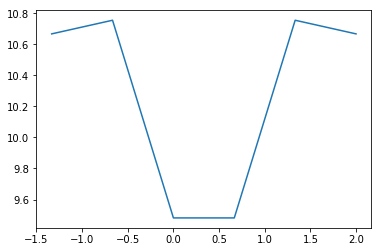

In [5]:
Q_val = [regression_var_criterion(X, y, el) for el in X[1:]]
plt.plot(X[1:], Q_val);

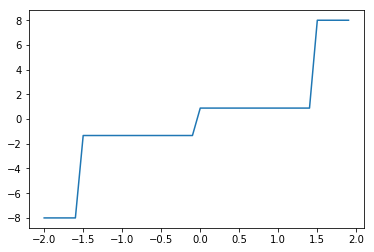

In [6]:
leaf1 = np.around(np.mean(y[X<-1.5]), decimals=2)
leaf2 = np.around(np.mean(y[(-1.5<=X) & (X<0)]), decimals=2)
leaf3 = np.around(np.mean(y[(0<=X) & (X<1.5)]), decimals=2)
leaf4 = np.around(np.mean(y[1.5<=X]), decimals=2)
t = np.arange(-2, 2, 0.1)
res = np.r_[
    [leaf1]*len(t[t<-1.5]),
    [leaf2]*len(t[(-1.5<=t) & (t<0)]),
    [leaf3]*len(t[(0<=t) & (t<1.5)]),
    [leaf4]*len(t[1.5<=t])
]
plt.plot(t, res);

In [22]:
df = pd.read_csv('../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [23]:
df['age_years'] = np.round(df.age / 365.25)
df = pd.concat([
    df,
    pd.get_dummies(df.cholesterol, prefix='cholesterol'),
    pd.get_dummies(df.gluc, prefix='gluc')], axis=1)
df = df.drop(['cholesterol', 'gluc'], axis=1)

In [24]:
X_df = df.drop(['cardio'], axis=1).values
y_df = df.cardio.values
X_train, X_valid, y_train, y_valid = train_test_split(X_df, y_df, test_size=0.3, random_state=17)

In [25]:
clf_tree = DecisionTreeClassifier(max_depth=3, random_state=17);
clf_tree.fit(X_train, y_train);

In [26]:
export_graphviz(clf_tree, feature_names=df.drop(['cardio'], axis=1).columns, 
out_file='../img/churn_tree.dot', filled=True)
!dot -Tpng '../img/churn_tree.dot' -o '../img/churn_tree.png'

In [27]:
tree_pred = clf_tree.predict(X_valid)
print(accuracy_score(y_valid, tree_pred))

0.72128571428571431

In [29]:
clf_tree_cv = DecisionTreeClassifier(random_state=17);
tree_params = {'max_depth': list(range(2, 11))}
tree_grid = GridSearchCV(
    clf_tree_cv,
    tree_params,
    cv=5,
    n_jobs=-1);
tree_grid.fit(X_train, y_train);

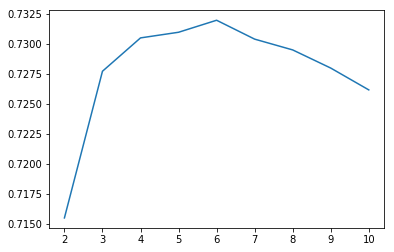

In [36]:
plt.plot(list(range(2, 11)), tree_grid.cv_results_['mean_test_score']);

In [37]:
print(tree_grid.best_params_)
tree_pred_cv = tree_grid.predict(X_valid)
print(accuracy_score(y_valid, tree_pred_cv))

{'max_depth': 6}
0.72580952381


In [39]:
acc1 = accuracy_score(y_valid, tree_pred)
acc2 = accuracy_score(y_valid, tree_pred_cv)
print((acc2 - acc1) / acc1 * 100)

0.627186901697


In [50]:
orig_df = pd.read_csv('../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

def age_categorical(age):
    if (age < 45 or age >= 65):
        return 0
    if age < 50:
        return 1
    if age < 55:
        return 2
    if age < 60:
        return 3
    if age < 65:
        return 4
    raise ValueError('bad value age: {0}'.format(age))

def ap_hi_categorical(ap):
    if (ap < 120 or ap >= 180):
        return 0
    if ap < 140:
        return 1
    if ap < 160:
        return 2
    if ap < 180:
        return 3
    raise ValueError('bad value ap_hi: {0}'.format(ap))

def gender_redefine(g):
    return g - 1

df['age_categorical'] = df.age_years.astype(int).apply(age_categorical)
df['ap_hi_categorical'] = df.ap_hi.astype(int).apply(ap_hi_categorical)
df['male'] = df.gender.astype(int).apply(gender_redefine)

df2 = pd.concat([
    pd.get_dummies(df.age_categorical, prefix='age_categ', drop_first=True),
    pd.get_dummies(df.ap_hi_categorical, prefix='ap_hi_categ', drop_first=True),
    df.smoke,
    pd.get_dummies(orig_df.cholesterol, prefix='cholesterol_categ'),
    df.male
], axis=1)

In [51]:
X_train = df2.values
y_train = df.cardio
clf_tree2 = DecisionTreeClassifier(max_depth=3, random_state=17);
clf_tree2.fit(X_train, y_train);

In [52]:
export_graphviz(clf_tree2, feature_names=df2.columns, 
out_file='../img/churn_tree2.dot', filled=True)
!dot -Tpng '../img/churn_tree2.dot' -o '../img/churn_tree2.png'